# Tutorial 2.a: Representing and Evaluating Uncertainty for Classification

The structure of this tutorial will mirror that of Tutorial 1.a. Tutorial 1.a focuses on regression problems, while the current tutorial focuses on classification problems. 

Before we start to work with any predictions, we must first think about how to represent our prediction. For example, when predicting image classes, we can represent the prediction as a categorical distribution over all possible labels, or as a set of likely labels. Each representation has its pros and cons. Depending on the different requirements during training/deployment, we may even want to convert between different representations. 
<!-- For example, we might initially start from an ensemble prediction (maybe because we trained multiple models), then convert it into a cumulative density function prediction or a point prediction (which are more interpretable and easier to work with). Conversion is one of the main features of torchuq, and we will come back to this topic in a later tutorial.  -->

This notebook aims to introduce some popular representations, as well as metrics to measure the quality of the predictions. 


We first list the types of predictions currently supported by torchuq for classification. You can skip this part and come back later as a reference.  

| Name          |  Variable type/shape  |  Special requirement | torchuq sub-module for evaluation | 
| -----------   |  --------------       |   -------- |  ------ |
| Topk          |  `int array [batch_size] or [batch_size, k]` |  Each element take values in `{0, 1, ..., num_classes}` | `torchuq.evaluate.topk` |                   
| Categorical   | `float32  array [batch_size, num_classes]` | Elements should be in $[0, 1]$ and sum to $1$ | `torchuq.evaluate.categorical` |
| USet          | `int array [batch_size, num_classes]` |   Elements are 0 or 1   | `torchuq.evaluate.uset` |
| Ensemble      | `dict: name -> prediction`  | name must start with prediction type and a string (with no special characters), such as 'categorical_1' | Unavailable



In [1]:
# We must first import the dependencies, and make sure that the torchuq package is in PYTHONPATH
# If you are running this notebook in the original directory as in the repo, then the following statement should work
import sys
sys.path.append('../..')   # Include the directory that contains the torchuq package
import torch  
from matplotlib import pyplot as plt

As a running example, we will use existing predictions for CIFAR-10. We first load these predictions. 

In [2]:

reader = torch.load('pretrained/resnet18-cifar10.pt')

# These functions transform categorical predictions into different types of predictions
# We will discuss transformations later, but for now we will simply use it to generate our example predictions
from torchuq.transform.direct import *
predictions_categorical = reader['categorical']
predictions_uset = categorical_to_uset(reader['categorical'])
predictions_top1 = categorical_to_topk(reader['categorical'], 1)
predictions_top3 = categorical_to_topk(reader['categorical'], 3)
labels = reader['labels']

### 1. Top-k Prediction

The simplest type of prediction specifies the top-k labels (i.e. the k most likely predicted labels). The labels are represented as integers $\lbrace 0, 1, \cdots, \text{n classes}-1 \rbrace$. A batch of top-k prediction is represented by an integer array of shape ```[batch_size, k]```, where ```predictions[i, :]``` is a sequence of labels (which are represented as integers). A top-1 prediction can be either represented as an array of shape ```[batch_size, 1]``` or more conveniently as an array of shape ```[batch_size]```. 

Here, we first verify that the loaded top3 and top1 predictions have the correct shape. 

In [3]:
print(predictions_top1.shape)
print(predictions_top3.shape)

torch.Size([10000])
torch.Size([10000, 3])


A very natural way to visualize the quality of a top-1 prediction is by the confusion matrix: among the samples that are predicted as class $i$, how many of them actually belong to class $j$. To plot a confusion matrix in torchuq use ```torchuq.evaluate.topk.plot_confusion_matrix```. 

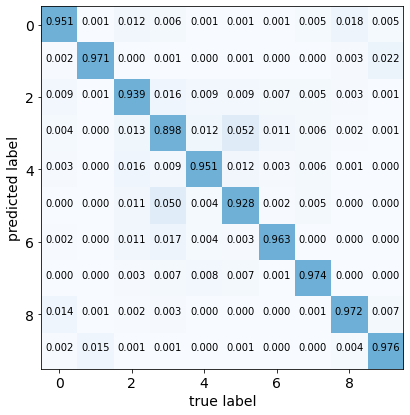

In [4]:
from torchuq.evaluate import topk
topk.plot_confusion_matrix(predictions_top1, labels);

We can also evaluate metrics for these predictions, such as accuracy 

In [5]:
print(topk.compute_accuracy(predictions_top1, labels))
print(topk.compute_accuracy(predictions_top3, labels))

tensor(0.9524)
tensor(0.9951)


### 2. Categorical Prediction 

The categorical prediction is perhaps the most useful prediction type for classification. This type of prediction returns the probability that a label is correct for each possible label. In torchuq a categorical prediction is represented as a float array of shape ```[batch_size, n_classes]```, where ```predictions[i, j]``` is the probability that the $i$-th sample takes the $j$-th label. 

In [6]:
print(predictions_categorical.shape)

torch.Size([10000, 10])



**Confidence Calibration**. Given a categorical prediction $p \in [0, 1]^{\text{n classes}}$, the confidence of the prediction is the largest probability in the array: $\max_i p_i$. If this largest probability is close to 1, then the prediction is highly confident. A simple but important requirement for this type of prediction is confidence calibration: among the samples with confidence $c$, the top-1 accuracy should also be $c$. For instance, if a model is 90% confident in each of 100 predictions, it should predict the correct label for 90 of the samples. If this property doesn't hold, then these confidence estimates are not meaningful.

We can visualize confidence calibration by plotting the reliability diagram, which plots the (actual) accuracy $a$ among samples with predicted confidence $c$ vs. the predicted confidence $c$. Ideally the predicted confidence $c$ will be equal to the actual accuracy $a$, so a perfectly calibrated model will yield a diagonal $a=c$ line. Deviations from this line represent miscalibration. As an example, we plot the reliability diagram for our example predictions below, and it is clear that the predictions are not well-calibrated. For example, among all samples with a confidence of about 0.9, the accuracy is only about 0.8. Hence the accuracy is lower than the confidence, and the predictions are over-confident. 

We can also compute the expected calibration error (ECE), which is a single number that measures mis-calibration. The ECE measures the average deviation from the ideal $a=c$ line. In practice, the ECE is approximated by binning --- partitioning the predicted confidences into bins, and then taking a weighted average of the
difference between the accuracy and average confidence for each bin. Pictorially, it is the average distance between the blue bars and the diagonal in the reliability diagram below. 

ECE-error is 0.0277


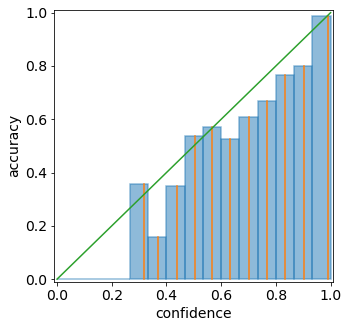

In [7]:
from torchuq.evaluate import categorical
categorical.plot_reliability_diagram(predictions_categorical, labels, binning='uniform');
print('ECE-error is %.4f' % categorical.compute_ece(predictions_categorical, labels, num_bins=15))

### 3. Uncertainty Set Prediction

The next type of representation is (uncertainty) set predictions. Uncertainty sets are almost the same as top-k; the main difference is that for top-k predictions, k must be specificed a priori, while for uncertainty sets, k can be different for each sample. In torchuq, uncertainty set predictions are represented by an integer array of shape ```[batch_size, n_classes]```, where ```predictions[i, j] = 1``` indicates that the $i$-th sample includes the $j$-th label in its uncertainty set, and ```predictions[i, j] = 0``` indicates that it is not. 

For set predictions, there are two important properties to consider: 

- The coverage: the frequency with which the true label belongs to the predicted set. A high coverage means that the true label almost always belong to the predicted set. 

- The set size: the number of elements in the prediction set

Ideally, we would like high coverage with a small set size. We compute the coverage and the set size of the example predictions below.

In [8]:
from torchuq.evaluate import uset

coverage = uset.compute_coverage(predictions_uset, labels)
size = uset.compute_size(predictions_uset)
print("The coverage is %.3f, average set size is %.3f" % (coverage, size))

The coverage is 0.987, average set size is 1.268
